In [1]:
import sys
from glob import glob

import time
import h5py
import zarr
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [4]:
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

In [5]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [6]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [7]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_72km = h5io['lon_80km'][...]
    lat_72km = h5io['lat_80km'][...]
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    land_mask_72km = h5io['land_mask_80km'][...]

In [8]:
data = np.load("/glade/work/ksha/NCAR/TEST_pred_lead2_new222.npy", allow_pickle=True)[()]
y_true = data['y_true']
y_pred = data['y_pred']

In [9]:
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*lead2.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*lead2.npy"))
filename_valid = filename_neg_valid + filename_pos_valid

In [10]:
base_v3_s = datetime(2018, 7, 15)
base_v3_e = datetime(2020, 12, 2)

base_v4_s = datetime(2020, 12, 3)
base_v4_e = datetime(2022, 7, 15)

base_ref = datetime(2010, 1, 1)

date_list_v3 = [base_v3_s + timedelta(days=day) for day in range(365+365+142)]
date_list_v4 = [base_v4_s + timedelta(days=day) for day in range(365+180)]

In [11]:
lead = 2

with h5py.File(save_dir_scratch+'SPC_all_lead{}.hdf'.format(lead-2), 'r') as h5io:
    record_1 = h5io['record_v3'][...]
    
with h5py.File(save_dir_scratch+'SPC_all_lead{}.hdf'.format(lead-1), 'r') as h5io:
    record_2 = h5io['record_v3'][...]
    
with h5py.File(save_dir_scratch+'SPC_all_lead{}.hdf'.format(lead), 'r') as h5io:
    record_3 = h5io['record_v3'][...]
    
with h5py.File(save_dir_scratch+'SPC_all_lead{}.hdf'.format(lead+1), 'r') as h5io:
    record_4 = h5io['record_v3'][...]
    
# record_1[np.isnan(record_1)] = 0
# record_2[np.isnan(record_2)] = 0
# record_3[np.isnan(record_3)] = 0
# record_4[np.isnan(record_4)] = 0

record_v3 = np.concatenate((record_1, record_2, record_3, record_4), axis=1)

shape_record = record_v3.shape

In [12]:
record_4.shape

(872, 600)

In [13]:
# y_pred[y_pred<0]=0
# y_pred[y_pred>1]=1

In [14]:
diff = y_pred[:, 0] - y_true

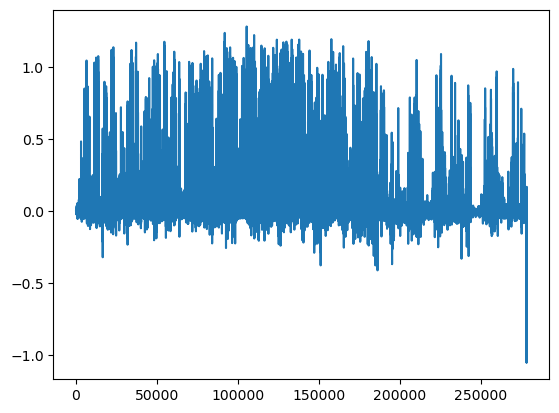

In [15]:
plt.plot(diff)

In [16]:
ind_miss = (np.argsort(diff))[::-1]

In [17]:
ind_top10 = ind_miss[:100]

In [18]:
filename_miss = []
day_miss = []
indx_miss = []
indy_miss = []

for ind in ind_top10:
    name = filename_valid[ind]
    day = int(name[45:48])
    try:
        indx = int(name[65:67])
    except:
        indx = int(name[65:66])
    try:
        indy = int(name[72:74])
    except:
        indy = int(name[72:73])
        
    filename_miss.append(name)
    day_miss.append(day)
    indx_miss.append(indx)
    indy_miss.append(indy)

In [19]:
day_start = 601
day_end = 871
shape_72km = lon_72km.shape

prob_grid = np.empty((day_end-day_start+1,)+shape_72km)
true_grid = np.empty((day_end-day_start+1,)+shape_72km)

prob_grid[...] = np.nan
true_grid[...] = np.nan

for i, name in enumerate(filename_valid):
    day = int(name[45:48])
    #flag = name[49:60]
    try:
        indx = int(name[65:67])
    except:
        indx = int(name[65:66])
    try:
        indy = int(name[72:74])
    except:
        indy = int(name[72:73])
    
    prob_grid[day-day_start, indx, indy] = y_pred[i]
    true_grid[day-day_start, indx, indy] = y_true[i]

In [20]:
edge = [-128, -70, 25, 50]

def aspc_cal(edge):
    return (edge[3]-edge[2])/(edge[1]-edge[0])

def gcd(a, b):
    if b == 0:
        return a
    else:
        return gcd(b, a % b)

# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [21]:
prob_grid[:, ~land_mask_72km] = np.nan

In [22]:
names = [
    'Max/Comp Radar',
    'MSLP',
    'AGL',
    'UH 2-5 km',
    'UH 0-2 km',
    'UH 0-3 km',
    'Vorticity 0-2 km',
    'Vorticity 0-1 km',
    'Graupel mass',
    'T 2m',
    'Dewpoint 2m',
    'U 10m',
    'V 10m',
    'SPD 10m',
    'APCP',
    'CAPE',
    'CIN',
    'SRH 0-3 km',
    'SRH 0-1 km',
    'U shear 0-1 km',
    'V shear 0-1 km',
    'U shear 0-6 km',
    'V shear 0-6 km']

name_pick = []
ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]

for i in ind_pick_from_batch:
    #print(names[i])
    name_pick.append(names[i])


In [23]:
name_pick

['Max/Comp Radar',
 'MSLP',
 'UH 2-5 km',
 'UH 0-2 km',
 'Graupel mass',
 'T 2m',
 'Dewpoint 2m',
 'SPD 10m',
 'APCP',
 'CAPE',
 'CIN',
 'SRH 0-3 km',
 'SRH 0-1 km',
 'U shear 0-6 km',
 'V shear 0-6 km']

/glade/scratch/ksha/DATA/NCAR_batch/VALID_day728_neg_neg_neg_indx26_indy49_lead2.npy


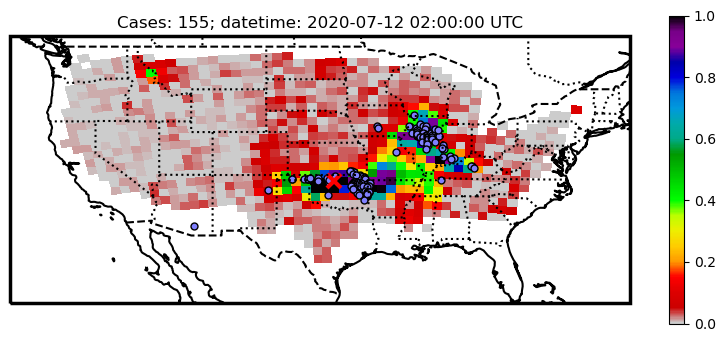

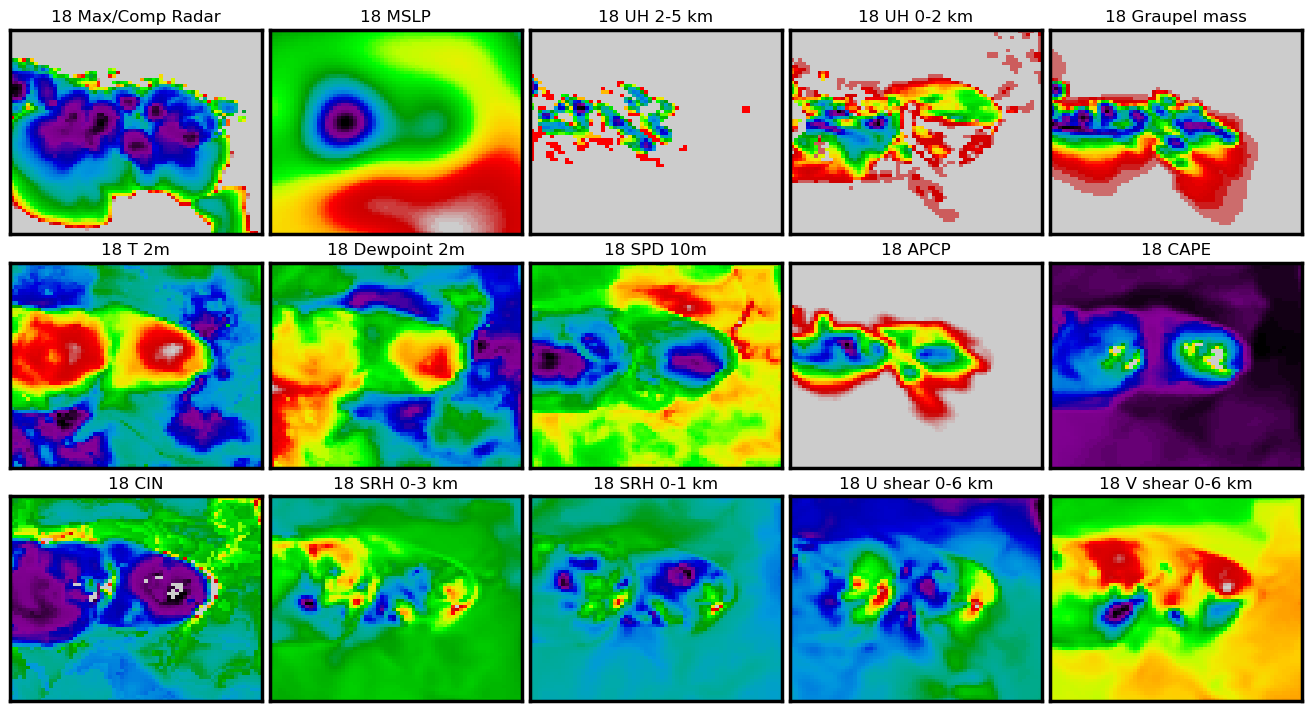

In [29]:
for m, day in enumerate(day_miss):
    if m==18:
        # dt_temp = date_list_v3[day]
        # dt_year = dt_temp.year
        # dt_nday = (dt_temp - datetime(dt_year, 1, 1)).days

        record_temp = record_v3[day, ...]

        lon_temp = []
        lat_temp = []

        for f in range(int(shape_record[-1]/2)):
            if np.logical_not(np.isnan(record_temp[2*f])):
                lon_temp.append(record_temp[2*f])
                lat_temp.append(record_temp[2*f+1])

        N_case = len(lon_temp)

        fig = plt.figure(figsize=(10, 4))
        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.set_extent(edge, ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=6)
        ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=6)
        ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=5)

        ax.spines['geo'].set_linewidth(2.5)

        CS = ax.pcolormesh(lon_72km, lat_72km, prob_grid[day-day_start, ...], vmin=0, vmax=1.0, cmap=plt.cm.nipy_spectral_r)
        ax.plot(lon_temp, lat_temp, 'ko', ms=5, mec='k', mew=1.0, mfc=[0.5, 0.5, 1.0])

        # ax.plot(lon_72km[indx_miss[m], indy_miss[m]], lat_72km[indx_miss[m], indy_miss[m]], 
        #     'x', ms=10, mec='k', mew=6.0, mfc='k')

        ax.plot(lon_72km[indx_miss[m], indy_miss[m]], lat_72km[indx_miss[m], indy_miss[m]], 
                'x', ms=10, mec='r', mew=3.0, mfc='r')

        ax.set_title('Cases: {}; datetime: {} UTC'.format(N_case, date_list_v3[day]+timedelta(hours=lead)))
        ax.set_xlabel('lon', fontsize=14)
        ax.set_ylabel('lat', fontsize=14)
        plt.colorbar(CS)

        #fig.savefig(fig_dir+'example_output_day{}.png'.format(day), format='png', **fig_keys)

        data = np.load(filename_miss[m])
        print(filename_miss[m])
        fig, AX = plt.subplots(3, 5, figsize=(13, 7), constrained_layout=True)
        AX = AX.ravel()
        for i, ax in enumerate(AX):
            ax = gu.ax_decorate_box(ax)
            try:
                ax.pcolormesh(data[0, ..., ind_pick_from_batch[i]], cmap=plt.cm.nipy_spectral_r)
                ax.set_title('{} '.format(m)+name_pick[i])
            except:
                continue

        #fig.savefig(fig_dir+'example_batch_day{}.png'.format(day), format='png', **fig_keys)

In [25]:
data = np.load('/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy35_lead2.npy')

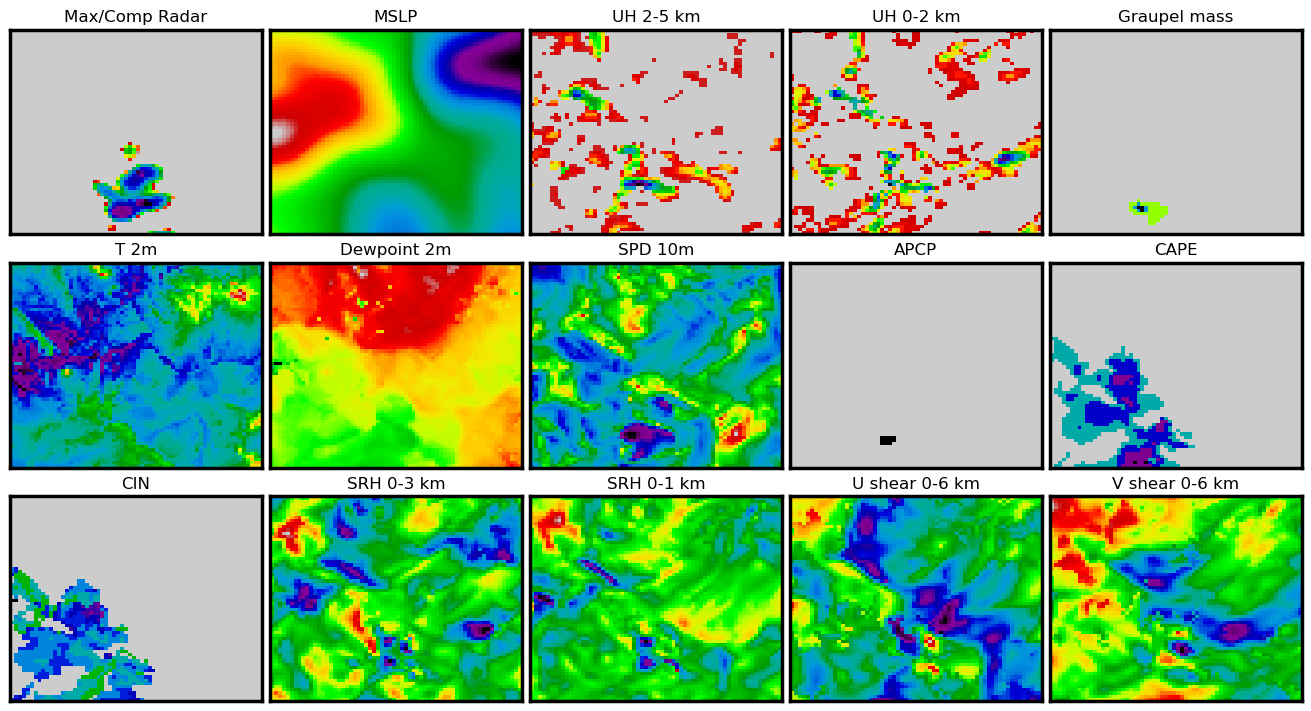

In [26]:
fig, AX = plt.subplots(3, 5, figsize=(13, 7), constrained_layout=True)
AX = AX.ravel()
for i, ax in enumerate(AX):
    ax = gu.ax_decorate_box(ax)
    try:
        ax.pcolormesh(data[0, ..., ind_pick_from_batch[i]], cmap=plt.cm.nipy_spectral_r)
        ax.set_title(name_pick[i])
    except:
        continue